<a href="https://colab.research.google.com/github/BaronVonBussin/NewTransit/blob/main/voodoo_bayesian_20250224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial State - End of Month
Expected Move: -19.48
95% Confidence Interval: [-80.36, 57.52]


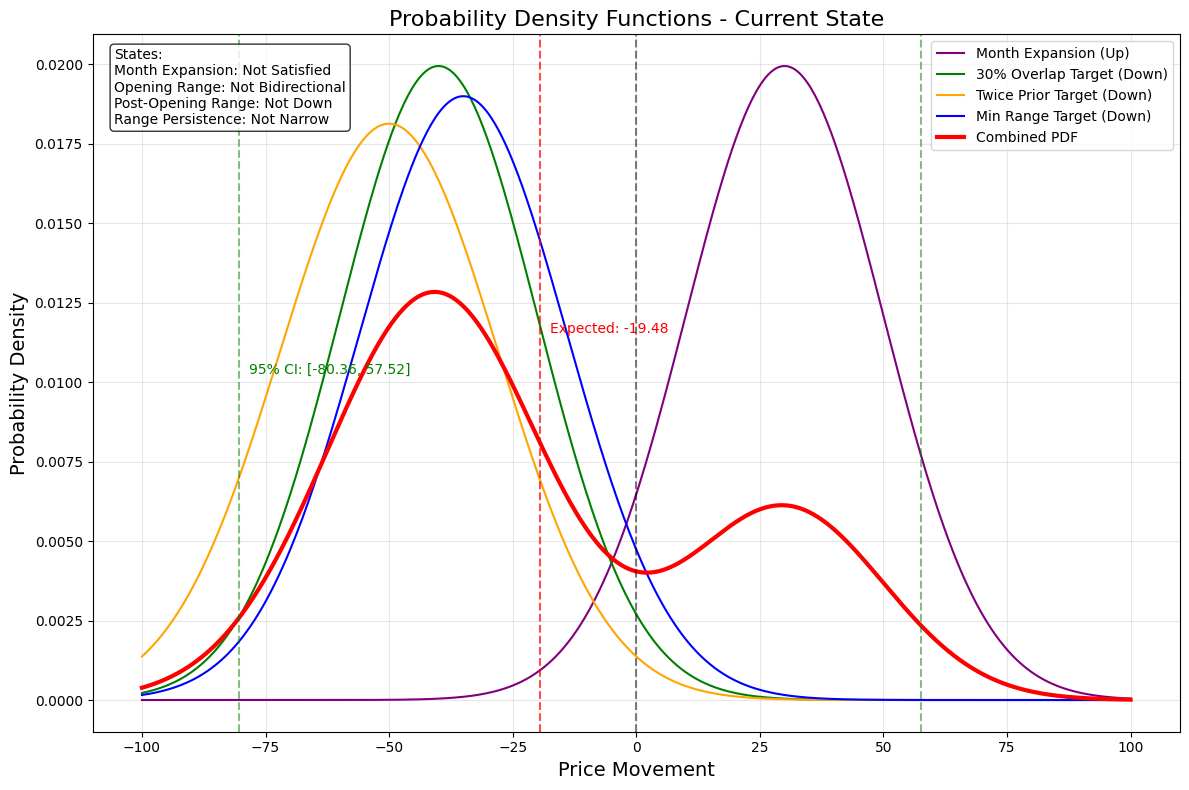


After Month Expansion Satisfied
Expected Move: -41.13
95% Confidence Interval: [-83.57, 0.60]


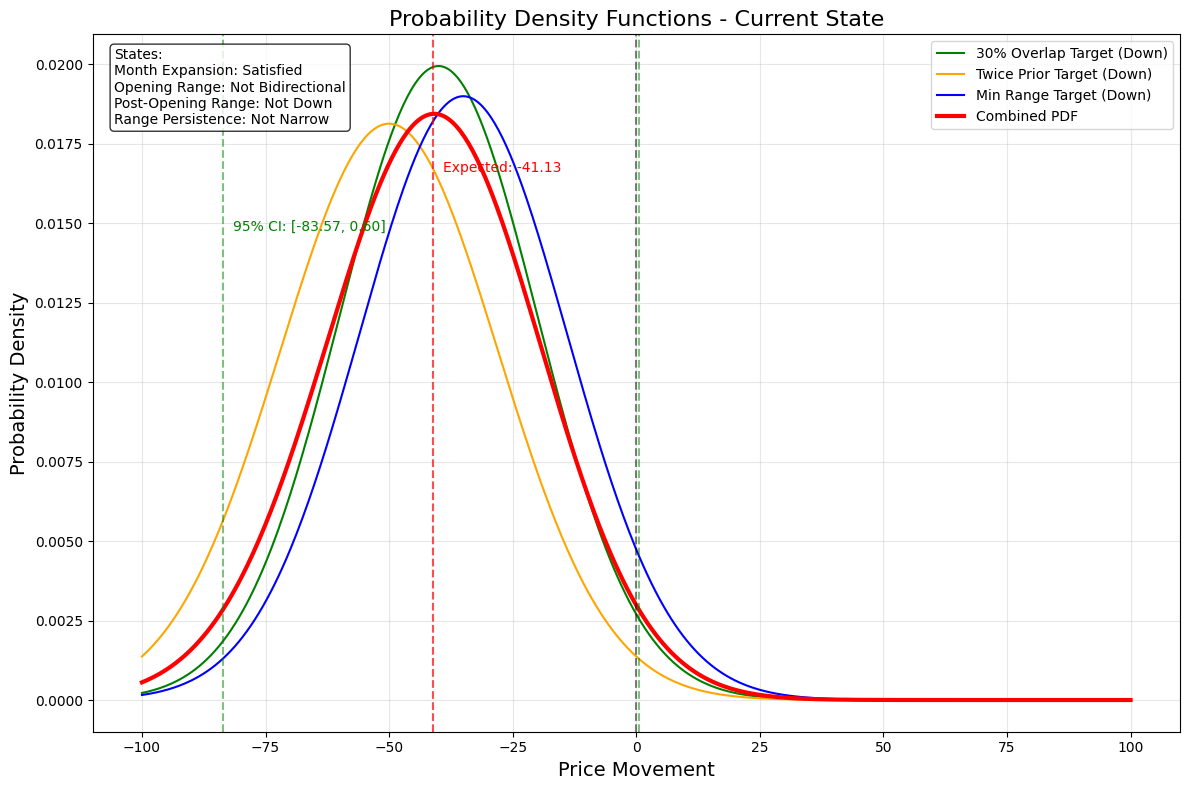


After Opening Range Bidirectional
Expected Move: -41.13
95% Confidence Interval: [-83.57, 0.60]


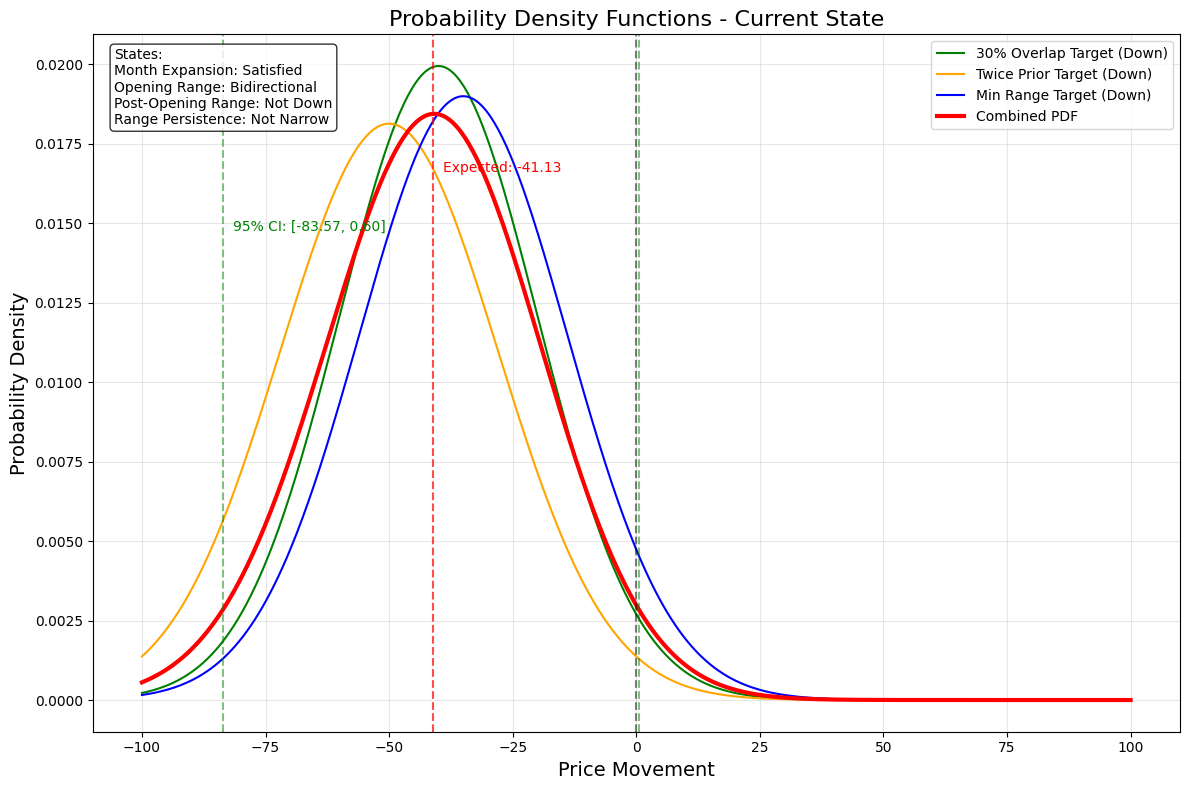


After Post-Opening Range Down
Expected Move: -43.36
95% Confidence Interval: [-77.56, -10.62]


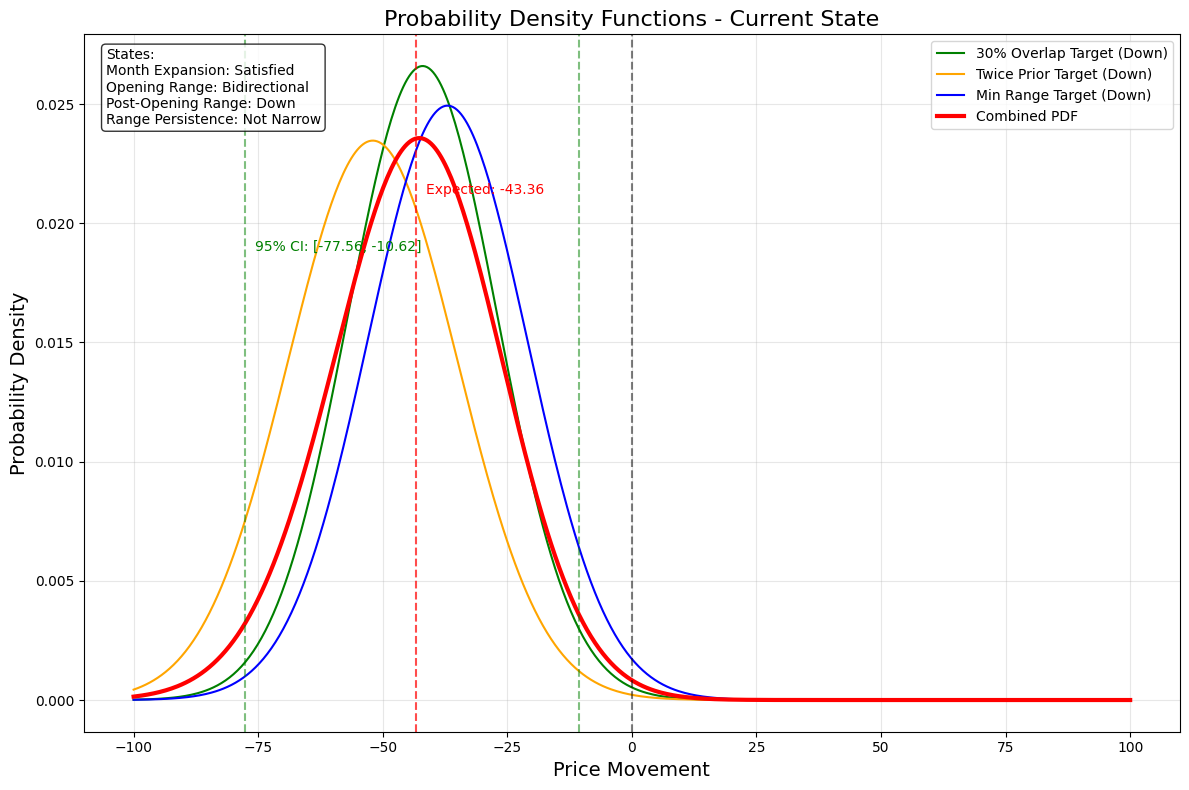


After Narrow Range Persistence Confirmed
Expected Move: -43.40
95% Confidence Interval: [-72.75, -16.23]


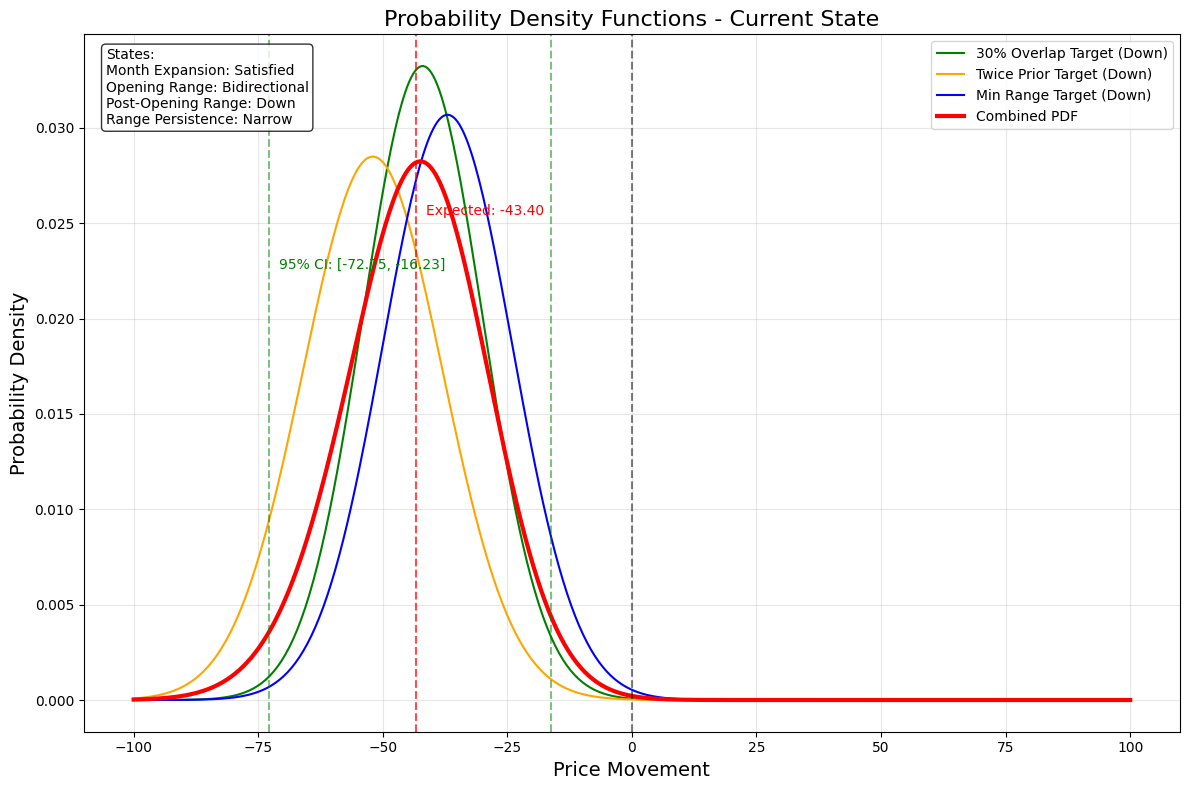


Plotting state evolution through all updates


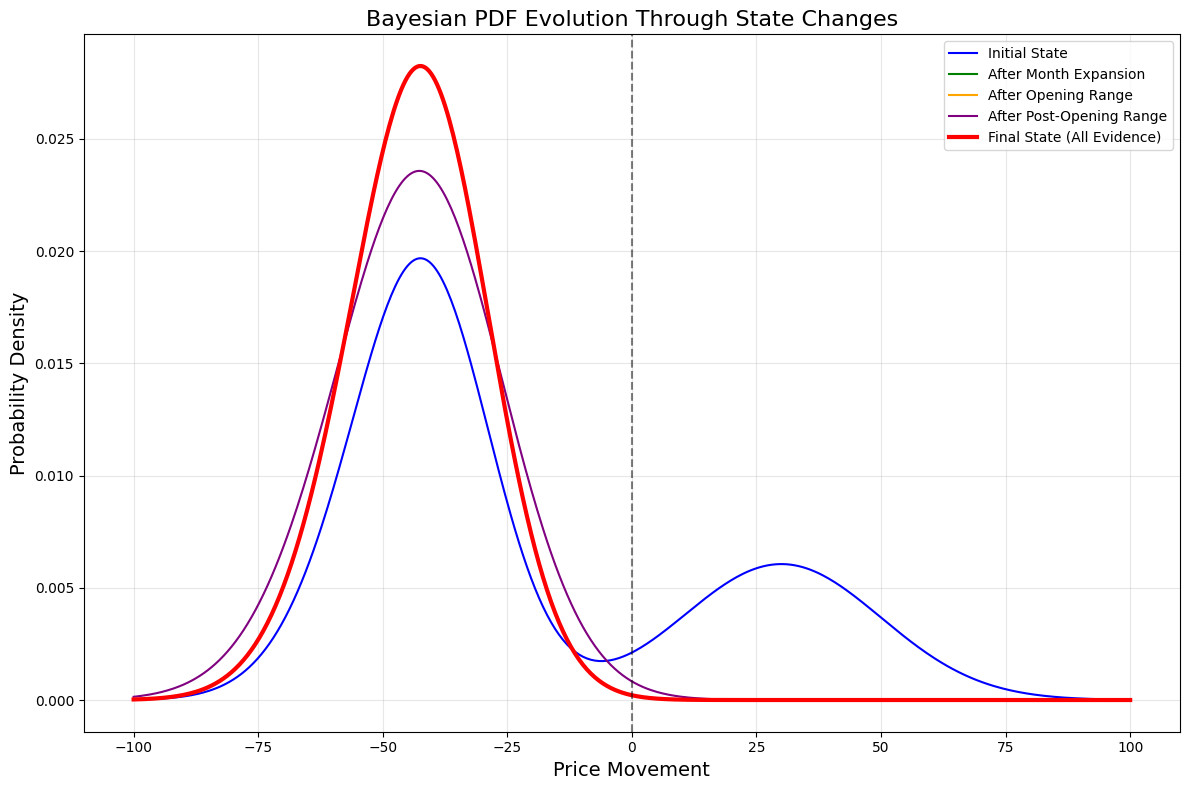

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns

class BayesianTradingFramework:
    """
    A Bayesian framework for analyzing market probabilities across multiple timeframes.
    """
    def __init__(self):
        # Price movement range for PDF calculations
        self.x_range = np.linspace(-100, 100, 500)

        # Initial state indicators
        self.month_expansion_satisfied = False
        self.opening_range_bidirectional = False
        self.post_opening_range_down = False
        self.narrow_range_persistence = False

        # Prior probabilities
        self.p_month_expansion = 0.85  # Upward bias from 91% percentR
        self.p_overlap_required = 0.70  # Downward bias for 30% overlap
        self.p_twice_prior_target = 0.60  # Downward bias for 50% target
        self.p_min_range = 0.65  # Downward bias for minimum monthly range

        # Initialize PDFs
        self.initialize_pdfs()

    def initialize_pdfs(self):
        """Initialize the probability density functions for each component."""
        # PDF for month expansion (upward bias)
        self.month_expansion_pdf = self._create_pdf(mu=30, sigma=20)

        # PDF for 30% overlap (downward bias)
        self.overlap_pdf = self._create_pdf(mu=-40, sigma=20)

        # PDF for twice prior month target (downward bias)
        self.twice_prior_pdf = self._create_pdf(mu=-50, sigma=22)

        # PDF for minimum range target (downward bias)
        self.min_range_pdf = self._create_pdf(mu=-35, sigma=21)

        # Combined PDF (weighted average of all PDFs)
        self.update_combined_pdf()

    def _create_pdf(self, mu, sigma):
        """Create a normal probability density function."""
        return norm.pdf(self.x_range, loc=mu, scale=sigma)

    def update_combined_pdf(self):
        """Update the combined PDF based on current state."""
        if not self.month_expansion_satisfied:
            # All PDFs contribute
            pdfs = [
                self.month_expansion_pdf,
                self.overlap_pdf,
                self.twice_prior_pdf,
                self.min_range_pdf
            ]
            weights = [
                self.p_month_expansion,
                self.p_overlap_required,
                self.p_twice_prior_target,
                self.p_min_range
            ]
        else:
            # Month expansion requirement satisfied, remove upward bias
            pdfs = [
                self.overlap_pdf,
                self.twice_prior_pdf,
                self.min_range_pdf
            ]
            weights = [
                self.p_overlap_required,
                self.p_twice_prior_target,
                self.p_min_range
            ]

            # Adjust PDFs based on additional information
            if self.opening_range_bidirectional:
                # Bidirectional opening range increases confidence
                pdfs = [pdf * 1.2 for pdf in pdfs]

            if self.post_opening_range_down:
                # Post-opening range down further increases confidence
                # and shifts distributions slightly
                self.overlap_pdf = self._create_pdf(mu=-42, sigma=15)
                self.twice_prior_pdf = self._create_pdf(mu=-52, sigma=17)
                self.min_range_pdf = self._create_pdf(mu=-37, sigma=16)
                pdfs = [
                    self.overlap_pdf,
                    self.twice_prior_pdf,
                    self.min_range_pdf
                ]

            if self.narrow_range_persistence:
                # Narrow range persistence makes distributions more peaked
                self.overlap_pdf = self._create_pdf(mu=-42, sigma=12)
                self.twice_prior_pdf = self._create_pdf(mu=-52, sigma=14)
                self.min_range_pdf = self._create_pdf(mu=-37, sigma=13)
                pdfs = [
                    self.overlap_pdf,
                    self.twice_prior_pdf,
                    self.min_range_pdf
                ]

        # Normalize weights
        weights = np.array(weights) / sum(weights)

        # Create combined PDF
        self.combined_pdf = np.zeros_like(self.x_range)
        for i, pdf in enumerate(pdfs):
            self.combined_pdf += weights[i] * pdf

        # Normalize combined PDF
        self.combined_pdf = self.combined_pdf / np.trapz(self.combined_pdf, self.x_range)

    def update_month_expansion(self, satisfied=True):
        """Update when month expansion requirement is satisfied."""
        self.month_expansion_satisfied = satisfied
        self.update_combined_pdf()

    def update_opening_range(self, bidirectional=True):
        """Update when opening range shows bidirectional expansion."""
        self.opening_range_bidirectional = bidirectional
        self.update_combined_pdf()

    def update_post_opening_range(self, down=True):
        """Update when post-opening range expands downward."""
        self.post_opening_range_down = down
        self.update_combined_pdf()

    def update_range_persistence(self, narrow=True):
        """Update when narrow range persists."""
        self.narrow_range_persistence = narrow
        self.update_combined_pdf()

    def calculate_expected_move(self):
        """Calculate expected move based on current PDF."""
        return np.sum(self.x_range * self.combined_pdf) / np.sum(self.combined_pdf)

    def calculate_confidence_interval(self, confidence=0.95):
        """Calculate confidence interval for the expected move."""
        # Create cumulative distribution function
        cdf = np.cumsum(self.combined_pdf) / np.sum(self.combined_pdf)

        # Find lower and upper bounds
        lower_bound_idx = np.argmin(np.abs(cdf - (1 - confidence) / 2))
        upper_bound_idx = np.argmin(np.abs(cdf - (1 + confidence) / 2))

        return self.x_range[lower_bound_idx], self.x_range[upper_bound_idx]

    def plot_current_state(self):
        """Plot the current state of all PDFs."""
        plt.figure(figsize=(12, 8))

        # Plot individual PDFs
        if not self.month_expansion_satisfied:
            plt.plot(self.x_range, self.month_expansion_pdf, label='Month Expansion (Up)', color='purple')

        plt.plot(self.x_range, self.overlap_pdf, label='30% Overlap Target (Down)', color='green')
        plt.plot(self.x_range, self.twice_prior_pdf, label='Twice Prior Target (Down)', color='orange')
        plt.plot(self.x_range, self.min_range_pdf, label='Min Range Target (Down)', color='blue')

        # Plot combined PDF
        plt.plot(self.x_range, self.combined_pdf, label='Combined PDF', color='red', linewidth=3)

        # Add reference line at zero
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

        # Calculate and show expected move
        expected_move = self.calculate_expected_move()
        plt.axvline(x=expected_move, color='red', linestyle='--', alpha=0.7)
        plt.text(expected_move + 2, max(self.combined_pdf) * 0.9,
                f'Expected: {expected_move:.2f}', color='red')

        # Calculate and show confidence interval
        lower, upper = self.calculate_confidence_interval()
        plt.axvline(x=lower, color='green', linestyle='--', alpha=0.5)
        plt.axvline(x=upper, color='green', linestyle='--', alpha=0.5)
        plt.text(lower + 2, max(self.combined_pdf) * 0.8,
                f'95% CI: [{lower:.2f}, {upper:.2f}]', color='green')

        # Add plot details
        plt.title('Probability Density Functions - Current State', fontsize=16)
        plt.xlabel('Price Movement', fontsize=14)
        plt.ylabel('Probability Density', fontsize=14)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)

        # Show state information
        state_text = f"States:\n" \
                    f"Month Expansion: {'Satisfied' if self.month_expansion_satisfied else 'Not Satisfied'}\n" \
                    f"Opening Range: {'Bidirectional' if self.opening_range_bidirectional else 'Not Bidirectional'}\n" \
                    f"Post-Opening Range: {'Down' if self.post_opening_range_down else 'Not Down'}\n" \
                    f"Range Persistence: {'Narrow' if self.narrow_range_persistence else 'Not Narrow'}"

        plt.annotate(state_text, xy=(0.02, 0.98), xycoords='axes fraction',
                    verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

    def plot_state_evolution(self):
        """Plot the evolution of the combined PDF through different states."""
        # Store current state
        current_expansion = self.month_expansion_satisfied
        current_opening = self.opening_range_bidirectional
        current_post_opening = self.post_opening_range_down
        current_narrow = self.narrow_range_persistence

        # Create figure
        plt.figure(figsize=(12, 8))

        # Initial state
        self.month_expansion_satisfied = False
        self.opening_range_bidirectional = False
        self.post_opening_range_down = False
        self.narrow_range_persistence = False
        self.update_combined_pdf()
        plt.plot(self.x_range, self.combined_pdf, label='Initial State', color='blue')

        # After month expansion
        self.month_expansion_satisfied = True
        self.update_combined_pdf()
        plt.plot(self.x_range, self.combined_pdf, label='After Month Expansion', color='green')

        # After opening range
        self.opening_range_bidirectional = True
        self.update_combined_pdf()
        plt.plot(self.x_range, self.combined_pdf, label='After Opening Range', color='orange')

        # After post-opening range
        self.post_opening_range_down = True
        self.update_combined_pdf()
        plt.plot(self.x_range, self.combined_pdf, label='After Post-Opening Range', color='purple')

        # Final state
        self.narrow_range_persistence = True
        self.update_combined_pdf()
        plt.plot(self.x_range, self.combined_pdf, label='Final State (All Evidence)', color='red', linewidth=3)

        # Add reference line at zero
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

        # Add plot details
        plt.title('Bayesian PDF Evolution Through State Changes', fontsize=16)
        plt.xlabel('Price Movement', fontsize=14)
        plt.ylabel('Probability Density', fontsize=14)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Restore current state
        self.month_expansion_satisfied = current_expansion
        self.opening_range_bidirectional = current_opening
        self.post_opening_range_down = current_post_opening
        self.narrow_range_persistence = current_narrow
        self.update_combined_pdf()


# Example usage

def run_example():
    """Run an example of the Bayesian Trading Framework based on our discussion."""
    # Create the framework
    btf = BayesianTradingFramework()

    print("Initial State - End of Month")
    print(f"Expected Move: {btf.calculate_expected_move():.2f}")
    lower, upper = btf.calculate_confidence_interval()
    print(f"95% Confidence Interval: [{lower:.2f}, {upper:.2f}]")
    btf.plot_current_state()

    # Day 1-5: Month expansion satisfied (expands prior month high)
    print("\nAfter Month Expansion Satisfied")
    btf.update_month_expansion(satisfied=True)
    print(f"Expected Move: {btf.calculate_expected_move():.2f}")
    lower, upper = btf.calculate_confidence_interval()
    print(f"95% Confidence Interval: [{lower:.2f}, {upper:.2f}]")
    btf.plot_current_state()

    # First 5 days: Opening range bidirectional
    print("\nAfter Opening Range Bidirectional")
    btf.update_opening_range(bidirectional=True)
    print(f"Expected Move: {btf.calculate_expected_move():.2f}")
    lower, upper = btf.calculate_confidence_interval()
    print(f"95% Confidence Interval: [{lower:.2f}, {upper:.2f}]")
    btf.plot_current_state()

    # Days 6-10: Post-opening range expands downward
    print("\nAfter Post-Opening Range Down")
    btf.update_post_opening_range(down=True)
    print(f"Expected Move: {btf.calculate_expected_move():.2f}")
    lower, upper = btf.calculate_confidence_interval()
    print(f"95% Confidence Interval: [{lower:.2f}, {upper:.2f}]")
    btf.plot_current_state()

    # Days 1-15: Narrow range persists
    print("\nAfter Narrow Range Persistence Confirmed")
    btf.update_range_persistence(narrow=True)
    print(f"Expected Move: {btf.calculate_expected_move():.2f}")
    lower, upper = btf.calculate_confidence_interval()
    print(f"95% Confidence Interval: [{lower:.2f}, {upper:.2f}]")
    btf.plot_current_state()

    # Show evolution through all states
    print("\nPlotting state evolution through all updates")
    btf.plot_state_evolution()


if __name__ == "__main__":
    run_example()